In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import pymc as pm
import scipy as sp
import pickle
from sklearn.preprocessing import MinMaxScaler, minmax_scale, scale, robust_scale
import patsy as pt
import arviz as az

In [2]:
protein = '1fme'
lag=41
proc=2


params = [['dihedrals', None], ['distances', 'linear'], ['distances', 'logistic']]
kernels = ['exponential', 'rbf', 'm32', 'm52']

# pre-processing params
data_cols = ['median', 'tica__dim', 'tica__lag', 'cluster__k', 'feature__value', 'distances__scheme', 'distances__transform', 
             'distances__steepness', 'distances__centre'
]
var_names_short = ['ts', 'dim', 'lag', 'states', 'feat', 'scheme', 'trans', 'steep', 'cent']
name_dict = dict(zip(data_cols, var_names_short))
scaling = dict(dim=[1, 20], lag=[1, 100],states=[10, 500], steep=[0, 50], cent=[0, 1.5])

# Load data
summary_path = f'{protein}/summary.h5'
hp_paths = ['../experiments/hpsample.h5', '../experiments/new_hpsample.h5']
hps = []
for hp_path in hp_paths:
    hp = pd.read_hdf(hp_path)
    hp.reset_index(inplace=True)
    hps.append(hp)
hps = pd.concat(hps)

    
timescales = pd.read_hdf(summary_path, key='timescales')
vamps = pd.read_hdf(summary_path, key='vamps')
timescales.reset_index(inplace=True)
vamps.reset_index(inplace=True)


# Create main data DF
data = timescales.query(f"process=={proc}").query(f'lag=={lag}')
data = data.merge(hps, on=['hp_ix'], how='left')
data = data.loc[:, data_cols+['hp_ix']]
data.rename(mapper=name_dict, axis=1, inplace=True)

# Add GMRQ from timescale: 

data['vamp2_eq'] = 1+np.exp(-lag/data['ts'])**2


In [8]:
data.head()

,ts,dim,lag,states,feat,scheme,trans,steep,cent,hp_ix,vamp2_eq,ts_log
0,1294.873024,12,92,65,distances,ca,logistic,26.322045,1.403330,28,1.938637,7.166168
1,2219.635968,11,4,433,distances,closest-heavy,logistic,2.303272,1.065951,216,1.963731,7.705098
2,2372.446243,16,86,197,distances,closest-heavy,linear,0.000000,0.000000,182,1.966027,7.771677
3,1289.806170,19,42,302,distances,closest-heavy,logistic,21.264394,1.439302,195,1.938403,7.162247
4,2270.543680,11,93,377,distances,closest-heavy,linear,0.000000,0.000000,199,1.964530,7.727775


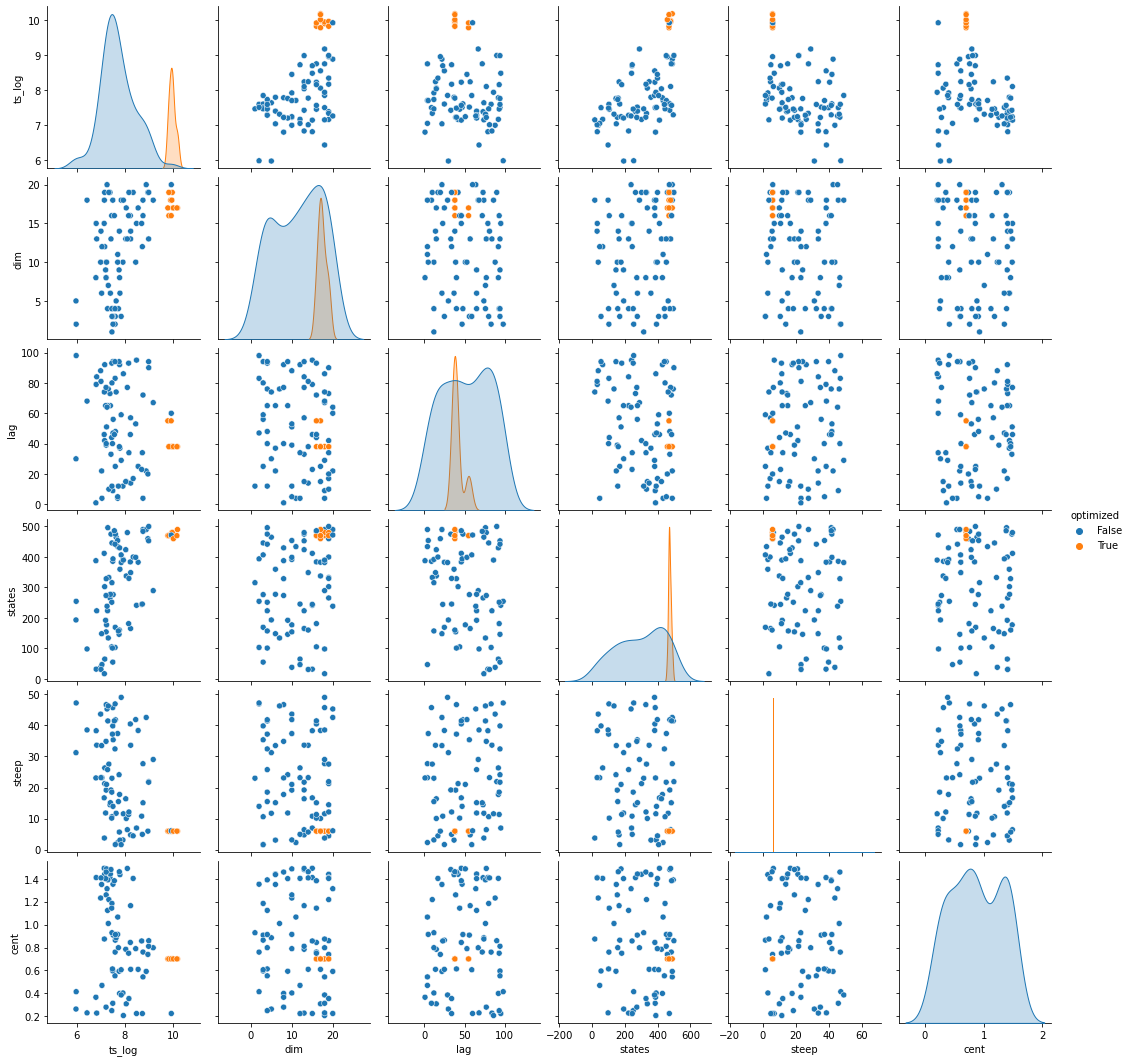

In [11]:
ix= (data.ts > np.quantile(data.ts, 0)) & (data.feat == 'distances') & (data.trans=='logistic') 
data['ts_log'] = np.log(data['ts'])

data['optimized'] = data['hp_ix']> 328

sns.pairplot(data.loc[ix, ['optimized', 'ts_log', 'dim', 'lag', 'states', 
                          'scheme', 'trans', 'steep', 'cent']], 
            hue='optimized')

In [12]:
data.loc[data.optimized, :]

,ts,dim,lag,states,feat,scheme,trans,steep,cent,hp_ix,vamp2_eq,ts_log,optimized
19,19883.009093,18,38,469,distances,ca,logistic,5.967568,0.700806,336,1.995884,9.897621,True
21,21743.272026,17,38,479,distances,ca,logistic,5.967568,0.700806,330,1.996236,9.987060,True
25,20894.220689,18,38,479,distances,ca,logistic,5.967568,0.700806,334,1.996083,9.947228,True
45,18502.544398,16,38,469,distances,ca,logistic,5.967568,0.700806,333,1.995578,9.825664,True
51,17721.858982,17,55,469,distances,ca,logistic,5.967568,0.700806,337,1.995384,9.782554,True
60,21264.736132,19,38,479,distances,ca,logistic,5.967568,0.700806,335,1.996151,9.964805,True
97,18482.723352,19,38,469,distances,ca,logistic,5.967568,0.700806,338,1.995573,9.824592,True
99,20346.682002,16,55,469,distances,ca,logistic,5.967568,0.700806,339,1.995978,9.920673,True
134,22322.204961,17,38,459,distances,ca,logistic,5.967568,0.700806,331,1.996333,10.013337,True
140,26428.342961,17,38,489,distances,ca,logistic,5.967568,0.700806,332,1.996902,10.182192,True
